<h1>ANALISI TEMPORALI SUI DATASET DI TWITTER</h1>

In [1]:
#questa cella contiene tutti gli import necessari
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px

In [3]:
#dataset = input("specifica il nome del file (senza estensione): ")
#dataset=dataset+".csv"
df = pd.read_csv("dfITEN.csv", low_memory=False, index_col = 0)
#To display maximum column width
pd.set_option('display.max_colwidth',None)

In [4]:
df.head()

,user,date,likeCount,tweetText,hashtags,lang,replies,retweetCount,replyCount,unique_id
0,jdemay,2023-02-05 23:59:16+00:00,0,"Planning to use #ChatGPT to help you with high school math? Maybe you should think twice, or at least consider a plan B. https://t.co/2ReLXamD30",['ChatGPT'],en,0.0,0.0,NaN,0
1,CarlosSilvaB81,2023-02-05 23:58:51+00:00,3,"@Carmtans @stkirsch Chat gpt, is nothing but a super search engine, programmed by woke 💩💩💩 . Stop calling it an AI.",NaN,en,0.0,0.0,NaN,1
2,saadnajeebsaad,2023-02-05 23:58:15+00:00,0,#WeatherUpdate #Karachi #Khi #TempUpdate #Sunrise #Sunset #HourlyUpdate\nSunrise: 07:12 AM Sunset: 06:19 PM\nCurrent Temp: 21 C\nHumidity: 88 %\nWind Speed: 11.124 km/hr\nStatus: Smoke\n2023-02-06 04:58 AM\nGenerated based on instructions from #chatgpt #openAI,"['WeatherUpdate', 'Karachi', 'Khi', 'TempUpdate', 'Sunrise', 'Sunset', 'HourlyUpdate', 'chatgpt', 'openAI']",en,0.0,0.0,NaN,2
3,RyanMac69987725,2023-02-05 23:58:07+00:00,0,@MKBHD But who is in the lead? Is it Microsoft after they acquired Chat GPT?,NaN,en,0.0,0.0,NaN,3
4,sjfcommo,2023-02-05 23:57:46+00:00,1,#ChatGPT seems like a great way to start creating content but I find it impersonal ~ my suggestion~ one needs to add heart and soul and authenticity into the content too. Any thoughts?,['ChatGPT'],en,0.0,0.0,NaN,4


<h2>Elaborazioni sulle date</h2>

In [ ]:
df['date'].info()

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', utc = True, errors='coerce')

In [ ]:
df['date'].info()

In [ ]:
oldestTweet = df['date'].min()
newestTweet = df['date'].max()
print("Il tweet più vecchio è del: "+ str(oldestTweet)+"\n"+"Il tweet più recente è del: "+ str(newestTweet))

In [ ]:
df['Year'] = df['date'].dt.year

In [ ]:
df['Month'] = df['date'].dt.month

In [ ]:
df['Day'] = df['date'].dt.day

In [ ]:
df['WeekDay'] = df['date'].dt.dayofweek

In [ ]:
df['hour'] = df['date'].dt.hour

In [ ]:
df['minutes'] = df['date'].dt.minute

In [ ]:
df['dayofYear'] = df['date'].dt.dayofyear

In [ ]:
df['date_only'] = df['date'].dt.date

In [ ]:
df.head(2) #nuova visualizzazione sul tempo

<p>Mapping dei giorni della settimana</p>

In [ ]:
weekday_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

df['WeekDay'] = df['WeekDay'].map(weekday_mapping)

In [ ]:
for day in df['WeekDay'].unique():
    print(day)

In [ ]:
df['WeekDay'].value_counts()

In [ ]:
plt.figure(figsize=(15,6))
custom_palette = ['#0000FF', '#800080', '#FFFF00']
sns.set_palette(custom_palette)
sns.countplot(data=df, x='WeekDay')
plt.show()

<p>Il giorno in cui le persone hanno twittato di più è il Giovedì. In linea di massima questa visualizzazione mostra che l'argomento ha una buona tenuta nell'arco dell'intera settimana, seppur con un incremento nella fase centro-iniziale della settimana.</p>

In [ ]:
df['date'].value_counts()

<h3>Comprensione dei peaks sui giorni (potenziale)</h3>

<p>Dai value counts risulta che il 30 marzo e il 2 febbraio sono i giorni con più tweets (entrambi giovedì).</p>

<p>Il 2 febbraio è stimato che già nel mese di gennaio, ChatGPT aveva un numero di active users pari a 100 milioni. L'uso incrementale dell'applicazione mostrava la più ampia crescita di utilizzo mai registrata da un chatbot</p>
<p>info disponibile qui <i>https://timelines.issarice.com/wiki/Timeline_of_ChatGPT#Full_timeline</i></p>

<p>Il 30 marzo  stato postato un software gratuito per dimostrare la potenza del language model di ChatGPT</p>
<p>info disponibile qui <i>https://timelines.issarice.com/wiki/Timeline_of_ChatGPT#Full_timeline</i></p>

<p><strong><i>Suddivisione del dataset in anni: 2022 e 2023</i></strong></p>

In [ ]:
df23 = df[df['Year']==2023]
df22 = df[df['Year']==2022]

In [ ]:
df22.head(2)

In [ ]:
df23.head(2)

In [ ]:
def askdf():
    ask = input("scegli dataset (1 per il dataset del 2022, 2 per il dataset del 2023): ")
    ans = df
    if ask == '1':
        ans = df22
    elif ask == '2':
        ans = df23
    else:
        print("errore inserimento, stai vedendo l'intero dataset e non uno specifico per anno. Ricompila!")
    return ans

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(data=askdf(), x='Month')
plt.show()

<p>Molti tweets appartengono alla fase inziale di gennaio 2023, periodo durante il quale sono emerse alcune controversie sulla natura dell'ideologia politica potenzialmente contenuta nelle risposte di ChatGPT.</p>
<p>info disponibile qui <i>https://timelines.issarice.com/wiki/Timeline_of_ChatGPT#Full_timeline</i></p>

In [ ]:
len_df = len(df)
len_df22 = len(df22)
len_df23 = len(df23)
print("Dataset totale, lunghezza = "+str(len_df))
print("Dataset 2022, lunghezza = "+str(len_df22))
print("Dataset 2023, lunghezza = "+str(len_df23))

<p>Il mese con più tweets del 2022 è dicembre</p>
<p>Il mese con più tweets del 2023 è gennaio</p>

<h2>Data preprocessing</h2>

<p>Rimozione di punteggiatura, caratteri speciali e stopwords</p>

In [5]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import re

def pre_process(text):
    # Remove links
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

    # Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    
    # Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    # Convert to lowercase
    text = text.lower()
    return text

In [6]:
stop_words = set(stopwords.words('english'))  # Import english stop words

In [7]:
def apply(df):
    df['tweetText_proc'] = df['tweetText'].apply(pre_process)
    df['tweetText_proc'] = df['tweetText_proc'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))  # Remove stop words
    return df

In [8]:
df = apply(df)

In [ ]:
df.head(3)

<h2>Sentiment Analysis</h2>

In [9]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
# Download NLTK resources (if not already downloaded)
nltk.download('vader_lexicon')

# Create an instance of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\claud\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
df['Sentiment'] = ''
for index, row in df.iterrows():
    comment = row['tweetText']
    scores = sia.polarity_scores(comment)
    compound_score = scores['compound']
    if compound_score > 0:
        sentiment = 'pos'
    elif compound_score < 0:
        sentiment = 'neg'
    else:
        sentiment = 'neu'

    df.loc[index, 'Sentiment'] = sentiment

sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

pos    138102
neu    122315
neg     47942
Name: Sentiment, dtype: int64


In [ ]:
df.head(2)

## Time analysis

C:\Users\claud\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


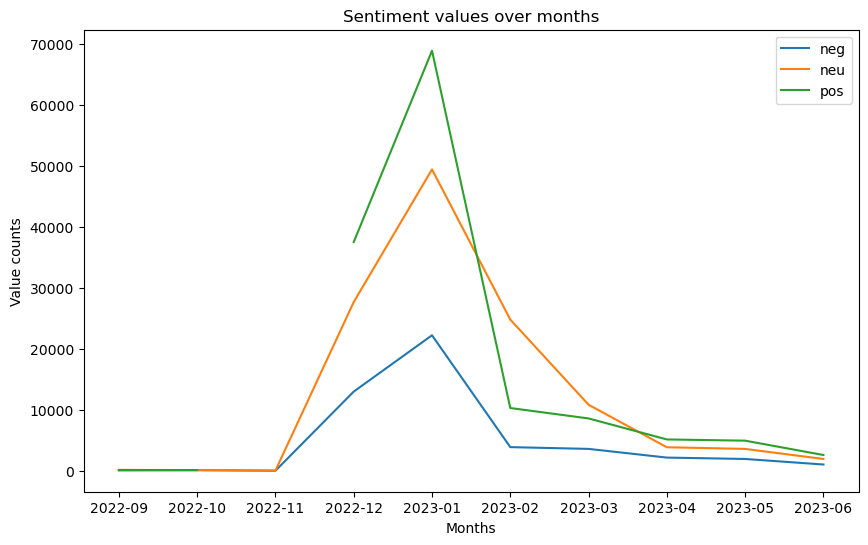

In [13]:
import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

df['date'] = pd.to_datetime(df['date'])
df_grouped = df.groupby([df['date'].dt.to_period('M'), 'Sentiment']).size().unstack()

df_grouped.index = df_grouped.index.astype(str)
plt.figure(figsize = (10, 6))
for col in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[col], label = col)

plt.legend()

plt.xlabel('Months')
plt.ylabel('Value counts')

plt.title('Sentiment values over months')
plt.legend()
plt.savefig('twitter_sentiment_time_analysis.png')
plt.show()

<p>Suddivido il dataset con sentiment in 2022 e 2023</p>

In [ ]:
def monthlySentiment(df, month):
    df_month = df[df['Month']== month]
    return df_month

In [ ]:
df22_sentiment = df[df['Year']==2022]
df23_sentiment = df[df['Year']==2023]

In [ ]:
# Filter the data for each year
df_2022 = df[df['Year'] == 2022]
df_2023 = df[df['Year'] == 2023]

# Define the sentiment categories and their order
sentiment_categories = ['pos', 'neg', 'neu']

# Calculate the counts for each sentiment category for 2022 and 2023
counts_2022 = df_2022['Sentiment'].value_counts()[sentiment_categories]
counts_2023 = df_2023['Sentiment'].value_counts()[sentiment_categories]

sns.set_palette("Spectral")

# Plot the histogram
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(sentiment_categories))

rects1 = ax.bar(index, counts_2022, bar_width, label='2022')
rects2 = ax.bar([i + bar_width for i in index], counts_2023, bar_width, label='2023')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Sentiment Distribution for 2022 and 2023')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(sentiment_categories)
ax.legend()

plt.show()


<p>Dal confronto, emerge che il sentimento si è distribuito in maniera sostanzialmente identica tra 2022 e 2023</p>

In [ ]:
def percentuali(dfmensile):
    vals = ['pos', 'neg', 'neu']
    for val in vals:
        tot = dfmensile['Sentiment'].value_counts()[val]
        counts = int(dfmensile['Sentiment'].value_counts()[val] / sum(dfmensile['Sentiment'].value_counts()) * 100)
        print(val + ":")
        print(str(counts)+"%"+"\nnumero tweets:" +str(tot))

In [ ]:
jan = monthlySentiment(df23_sentiment, 1)
percentuali(jan)

In [ ]:
feb = monthlySentiment(df23_sentiment, 2)
percentuali(feb)

In [ ]:
mar = monthlySentiment(df23_sentiment, 3)
percentuali(mar)

In [ ]:
apr = monthlySentiment(df23_sentiment, 4)
percentuali(apr)

In [ ]:
may = monthlySentiment(df23_sentiment, 5)
percentuali(may)

In [ ]:
jun = monthlySentiment(df23_sentiment, 6)
percentuali(jun)

<p>Per ciascun mese i positivi superano negativi e neutri, ma con un margine di differenza dell'1-2% a seconda del mese.</p>

In [ ]:
from textblob import TextBlob
df2 = df.copy() #creo una copia per sicurezza
sid = SentimentIntensityAnalyzer()

In [ ]:
df['blob_polarity'] = df['tweetText'].map(lambda text: sid.polarity_scores(text)['compound']) 

In [ ]:
# Calcolo la polarità con Vader
df['vader_polarity'] = df['tweetText'].map(lambda text: sid.polarity_scores(text)['compound']) 

In [ ]:
# Combine both polarities to make a dataframe
polarity_df = df[['vader_polarity', 'blob_polarity']]
polarity_df = polarity_df.rename(columns={'vader_polarity': 'Vader','blob_polarity': 'TextBlob'})

# Plot a historam to compare the polarities of both the methods
fig = px.histogram(polarity_df, x=['Vader', 'TextBlob'], nbins=40, barmode='group', color_discrete_sequence=['#1DA1F2', '#00CC96'])
fig.update_layout(title='Distributions of sentimental polarities Vader Vs. TextBlob', xaxis_title='Polarity', yaxis_title='Count',width=1200, height=800)
fig.show()

<p>Questo grafico mostra la distribuzione del sentimento sull'intero dataset (che comprende 22/23) per mostrare come  nltk sia in grado di recepire un più ampio range di valori di sentimento rispetto a textBlob. In linea di massima mi interessa evidenziare come la sentiment analysis su chatgpt dia in ogni caso esiti positivi da parte delle persone/account che hanno twittato.</p>

<h1>Word Frequency by Year</h1>

In [ ]:
import pandas as pd
import seaborn as sns

from nltk import FreqDist
from nltk.tokenize import word_tokenize

<h3>Tweets relativi al 2022</h3>

<p>Suddivido il dataset del 2022 in tre sotto-datasets, uno per ciascuna categoria di sentimento</p>

In [ ]:
df22_pos = df22_sentiment[df22_sentiment['Sentiment']=='pos']
df22_neg = df22_sentiment[df22_sentiment['Sentiment']=='neg']
df22_neu = df22_sentiment[df22_sentiment['Sentiment']=='neu']

In [ ]:
df22_list= [df22_pos, df22_neg, df22_neu]

<p>Osservo le 50 parole più frequenti</p>

In [ ]:
def cinquantaParole(df, boolean):
    tokens = []
    for row in df['tweetText']:
        tokens.extend(word_tokenize(str(row).lower()))  # Tokenization and lower conversion of the strings

    word_freq = FreqDist(tokens)
    sorted_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=boolean)
    banned_w = ['chatgpt', 'ai', ' ai', 'ai ', 'gpt', 'openai', 'artificialintelligence', 'amp', 'https']
    sorted_freq = [(word, freq) for word, freq in sorted_freq if word not in banned_w]
    return sorted_freq

def createDffreqs(sorted_freq):
    freq_df = pd.DataFrame(sorted_freq, columns=['word', 'frequency'])
    freq_df.sort_values(by='frequency', ascending=False, inplace=True)
    return freq_df

In [ ]:
N = 30  #numero parole, cambiare se necessario
colors = ['Greens', 'Reds', 'Purples']

In [ ]:
for i, df in enumerate(df22_list):
    sorted_freq = cinquantaParole(df, True)
    
    top_words = createDffreqs(sorted_freq).head(N) #prendo le n parole più frequenti

    top_words_styled = top_words[:30].style.background_gradient(cmap=colors[i])
    
    sentiment = ['Positive', 'Negative', 'Neutral'][i]  #Metto l'etichetta
    
    top_words_styled.caption = f"Top 30 parole più frequenti nel 2022 (tweets con sentimento {sentiment})"
    
    display(top_words_styled)  #Mostro il dataset


In [ ]:
top10_2022_general = createDffreqs(cinquantaParole(df22_sentiment, False)).head(10) #prendo le n parole più frequenti
top10_2022_general

In [ ]:
import plotly.express as px

fig = px.treemap(top10_2022_general, path=['word'], values='frequency', title="Top 20 parole nei tweets")
fig.update_layout(autosize=False, width=800, height=600)
fig.show()


<h3>Tweets relativi al 2023</h3>

<p>Suddivido il dataset del 2023 in tre sotto-datasets, uno per ciascuna categoria di sentimento</p>

In [ ]:
df23_pos = df23_sentiment[df23_sentiment['Sentiment']=='pos']
df23_neg = df23_sentiment[df23_sentiment['Sentiment']=='neg']
df23_neu = df23_sentiment[df23_sentiment['Sentiment']=='neu']

In [ ]:
df23_list= [df23_pos, df23_neg, df23_neu]

In [ ]:
for i, df in enumerate(df23_list):
    sorted_freq = cinquantaParole(df, True)
    
    top_words = createDffreqs(sorted_freq).head(N) #prendo le n parole più frequenti
    
    top_words_styled = top_words[:30].style.background_gradient(cmap=colors[i])
    
    sentiment = ['Positive', 'Negative', 'Neutral'][i]  #Metto l'etichetta
    
    top_words_styled.caption = f"Top 30 parole più frequenti nel 2023 (tweets con sentimento {sentiment})"
    
    display(top_words_styled)  #Mostro il dataset

In [ ]:
top10_2023_general = createDffreqs(cinquantaParole(df23_sentiment)).head(10) #prendo le n parole più frequenti
top10_2023_general

In [ ]:
fig = px.treemap(top10_2023_general, path=['word'], values='frequency', title="Top 20 parole nei tweets")
fig.update_layout(autosize=False, width=800, height=600)
fig.show()

<h1>Bigrams, trigrams</h1>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def get_top_n_ngrams(corpus, n=None, ngram=2, exclude_keywords=None):
    if exclude_keywords is None:
        exclude_keywords = []
        
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Exclude n-grams containing specified keywords
    words_freq = [item for item in words_freq if not any(keyword in item[0] for keyword in exclude_keywords)]

    return words_freq[:n]

In [ ]:
#prendo i bigrammi e i trigrammi divisi per 2022 e 2023

In [ ]:
# top 20 bigrammi 2022
#common_bigrams = get_top_n_ngrams(df22_sentiment['tweetText'], 20, ngram=2, exclude_keywords=['chat', 'gpt', 'chatgpt','httpstcorlyimpqw', 'ai'])

In [ ]:
# top 20 bigrammi 2023
#common_bigrams23 = get_top_n_ngrams(df23_sentiment['tweetText'], 20, ngram=2, exclude_keywords=['chat', 'gpt', 'chatgpt','httpstcorlyimpqw', 'ai'])

In [ ]:
# top 20 trigrammi 2022
common_trigrams = get_top_n_ngrams(df22_sentiment['tweetText'], 20, ngram=3, exclude_keywords=['chat', 'gpt', 'chatgpt','httpstcorlyimpqw', 'ai'])

In [ ]:
# top 20 trigrammi 2023
common_trigrams23 = get_top_n_ngrams(df23_sentiment['tweetText'], 20, ngram=3, exclude_keywords=['chat', 'gpt', 'chatgpt',' httpstcorlyimpqw', 'ai', 'sunset', 'sunrise','current', 'temp', 'pm'])

In [ ]:
#df_bigrams22 = pd.DataFrame(common_bigrams, columns=['NgramText', 'count'])
#df_bigrams23 = pd.DataFrame(common_bigrams23, columns=['NgramText', 'count'])
df_trigrams22 = pd.DataFrame(common_trigrams, columns=['NgramText', 'count'])
df_trigrams23 = pd.DataFrame(common_trigrams23, columns=['NgramText', 'count'])

<p>Mostro la <strong>frequenza generale</strong> dei bigrammi nei tweets del 2022</p>

In [ ]:
#fig_bigrams = px.bar(df_bigrams22[1:], x='NgramText', y='count', title='Conteggio Bigrammi sul 2022', color = 'count',width=1000, height=600)
#fig_bigrams.show()

In [ ]:
#fig_bigrams = px.bar(df_bigrams23[1:], x='NgramText', y='count', title='Conteggio Bigrammi sul 2023', color = 'count',width=1000, height=600)
#fig_bigrams.show()

In [ ]:
fig_trigrams = px.bar(df_trigrams22, x='NgramText', y='count', title='Conteggio Trigrammi sul 2022', color = 'count',width=1000, height=600)
fig_trigrams.show()

In [ ]:
fig_bigrams = px.bar(df_trigrams23[1:], x='NgramText', y='count', title='Conteggio Trigrammi sul 2023', color = 'count',width=1000, height=600)
fig_bigrams.show()

<p>I bigrammi sono centrati soprattutto sull'uso di ChatGPT, ricorrono temi come ‘write’, ‘ask’, ‘tools’, ‘search engine’, etc.</p>

<p>Alcuni bigrammi mostrano che chatgpt ha molte applicazioni con l'informatica e il coding in generale.</p>

<p>Anche i trigrammi mostrano un andamento similare, in particolare, vediamo la comparsa di alcune combinazioni di rilievo come l'associazionedi chitgpt a search engine. Indice che forse  in una fase inizale si cercava di comprendere a cosa servisse chatgpt.</p> 

<p>Nella maggior parte dei casi ricorrono anche i temi relativi al language model (vedi relazione con periodo febbraio/marzo)</p>

<h1>ANALISI MENSILE DEI TRIGRAMMI NEL DATASET DI COMMENTI</h1>

In [ ]:
#Ricerche dei trigrammi per ogni mese
def trigrammaMese(month):
    df_tmp = df23_sentiment[df23_sentiment['Month']==month]
    trig = get_top_n_ngrams(df_tmp['tweetText'], 20, ngram=3, exclude_keywords=['chat', 'gpt', 'chatgpt',' httpstcorlyimpqw', 'ai', 'sunrise', 'sunset', 'Karachi', 'whether'])
    df = pd.DataFrame(trig, columns=['NgramText', 'count'])
    return df

In [ ]:
month = input("Inserisci un numero corrispondente al mese scelto: ")
monthparam = int(month)

if monthparam >= 1 and monthparam <= 12:
    dfmonth = trigrammaMese(monthparam)
    # Resto del codice per elaborare i risultati dei trigrammi
else:
    print("Mese non valido. Inserisci un numero compreso tra 1 e 12.")


In [ ]:
def convert_number_to_month(number):
    if number == 1:
        return 'January'
    elif number == 2:
        return 'February'
    elif number == 3:
        return 'March'
    elif number == 4:
        return 'April'
    elif number == 5:
        return 'May'
    elif number == 6:
        return 'June'
    elif number == 7:
        return 'July'
    elif number == 8:
        return 'August'
    elif number == 9:
        return 'September'
    elif number == 10:
        return 'October'
    elif number == 11:
        return 'November'
    elif number == 12:
        return 'December'
    else:
        return None  # handle invalid input

In [ ]:
nomemese = convert_number_to_month(monthparam)
fig_bigrams = px.bar(dfmonth[1:], x='NgramText', y='count', title='Conteggio Trigrammi sul {} 2023'.format(nomemese), color = 'count',width=1000, height=600)
fig_bigrams.show()

<h3>Alcune riflessioni sui dati (mensili per il 2023)</h3>
<p>
    <ul>
        <li>Gennaio: nel mese di Gennaio i trigrammi con maggior rilievo risultano quelli relativi alla questione del "python deeplearning" al "coding". Tra i trigrammi più frequenti si trovano anche quelli relativi alla questione del trading, numerose volte viene citato il termine "bitcoin" affiancato da "fintech" e "cybersecurity".
            Da notare anche la presenza di un trigramma "medical licensing exam" relativo all'uso di chatgpt nella fase di ammissione agli esami di medicina.<strong> Note di rilievo:</strong> sussiste molto rumore dovuto ai tweets che parlano di <i>Wheather updates</i> e <i>metereologia in genere</i>. Si potrebbe decidere di filtrare ulteriormente i risultati per escludere queste conclusioni oppure verificare di cosa si tratta.</li>
        <li>Febbraio: nel mese di Febbraio si trova un trigramma interessante <i>faster response times</i> che è sicuramente relativo all'uso di chatGPT e ad una sua accezione positiva. Il trigramma <i>Million monthly active</i> invece dovrebbe essere riferito alla notizia della crescita esponenziale di utilizzatori di chat gpt uscita proprio agli inizi di Febbraio. Abbiamo anche un riferimento alle <i>generated based instructions</i>, modo di utilizzo dell'intelligenza artificiale e del LM previsto da chatgpt. <strong>Note di rilievo:</strong> ancora una volta si trova rumore sulle tematiche della temperatura e della velocità del vento. Un buon volume di tweets riguarda minecraf, perché?</li>
        <li>Marzo: i trigrammi con maggiore frequenza sono relativi alla questione del ban di chatgpt in italia e ai plugin del browser in grado di far girare comunque l'applicazione. Ancora una volta si trova il trigramma <i>large language model</i>. Rimangono numerosi trigrammi su tematiche di tipo gaming, relativi a nintendo, minecraft e fantasy in genere, perché?</li>
        <li>Aprile: qui il trigramma più frequente risulta a tema <i>NFT</i> ed è <i>short recommendation ticker</i>. Per il resto emergono ancora risultati sulla questione del ban italiano, soprattutto relative alla ragione (vd. <i>reason italy banned</i>). Si nota un incremento dei trigrammi relativi al trading e alle criptovalute, come già evidenziato in gennaio-febbraio. In particolare relativi al <i>candle price</i>, una tecnica per incrementare i profitti.</li>
        <li>Maggio: alcuni trigrammi mostrano l'interesse nei tweeters per la questione del tribunale di NY, a quanto pare qualcuno aveva usato chatgpt per scrivere un discorso per il tribunale (?= controlla notizia), finendo con l'usare notizie false. Inoltre parte dei trigrammi rivelano informazioni sul tema dell'educazione e il timore che le nuove generazioni siano meno capaci o più capaci per colpa/merito dello strumento. </li>
        <li>Giugno: a Norimberga viene generato un sermone con chatgpt, i trigrammi rivelano che questa questione è stata discussa su twitter. Chatgpt come fonte religiosa con conseguenze negative/positive sul pensiero delle persone. Inoltre compaiono tra i più frequenti i trigrammi relativi al <i>fights experts</i> una questione di rilievo e preoccupazione, ovvero se chatgpt sia in grado di "combattere" gli esperti sulle loro discipline di applicazione. 
        </li>
    </ul>
</p>

<h2>Topic Modelling con LDA</h2>

In [ ]:
from nltk.stem import WordNetLemmatizer  # Add this import statement
import gensim
from gensim import corpora, models

In [ ]:
# Let's sort the dataframe and get top 10000 most liked tweets
df_sorted = df.sort_values(by='likeCount', ascending=False)
df_top_10000 = df_sorted.iloc[:10000]

In [ ]:
df_top_10000

In [ ]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
docs = df_top_10000['tweetText'].apply(lambda x: [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])

In [ ]:
# Create a dictionary of words and their frequency
dictionary = corpora.Dictionary(docs)

In [ ]:
# Create a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in docs]

# Topic modeling using LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print('\n')

<h2>Cerco di interpretare i risultati del topic modelling con LDA</h2>

<ul>
    <li><strong>Topic 1: </strong>Asking questions and getting better answers that are generated from facts,</li>
    <li><strong>Topic 2: </strong>Discussions about the use of ChatGPT as unique tool that can help in generating something,</li>
    <li><strong>Topic 3: </strong>ChatGPT e OpenAI as gaming supporter but also its risks with its usage,</li>
    <li><strong>Topic 4: </strong>The questions about the intelligence of chatGPT and the future questions about its use,</li>
    <li><strong>Topic 5: </strong>Articles that explains the ChatGPT role in learning and generating some good answer about coding,</li>
    <li><strong>Topic 6: </strong>The question of chatGPT as future poem writer and all of its creative applications,</li>
    <li><strong>Topic 7: </strong>ChatGPT and its scholastic uses, is it good or bad for education,</li>
    <li><strong>Topic 8: </strong>Probably students are loving the human language generator and obviously using it,</li>
    <li><strong>Topic 9: </strong>AI tools, their use in the workplace, and their potential impact on various tasks such as writing.</li>
</ul>

<h3>Analisi per topic</h3>

<p>Per questa analisi dovrò reimportare le librerie e un dataset misto tra italiano e inglese</p>

In [19]:
import string
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px

In [9]:
# inizializzo nltk con i download necessari
nltk.download('stopwords')
nltk.download('punkt')

#Controllo il linguaggio e rimuovo le stopwords per caso
def get_stop_words(lang):
    if lang == 'en':
        return nltk.corpus.stopwords.words('english')
    elif lang == 'it':
        return nltk.corpus.stopwords.words('italian')
    else:
        return []

#Rimozione stopwords
def remove_stop_words(text, stop_words):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

# Read the DataFrame
df = pd.read_csv('dfITEN.csv')  # Replace 'your_data.csv' with your actual data file

# Apply stop words removal
df['lang'] = df['lang'].fillna('')  #per riempire eventuali vuoti (non dovrebbero essercene)
df['stop_words'] = df['lang'].apply(get_stop_words)
df['stop_content'] = df['tweetText'].apply(lambda x: remove_stop_words(x, stop_words=df['stop_words']))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utente\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
print("dimensione dataset: "+ str(len(df)))

dimensione dataset: 308359


In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

#polarità calcolata con vader
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
df['vader_polarity'] = df['tweetText'].map(lambda text: sid.polarity_scores(text)['compound']) 

#polarità con textblob
df['blob_polarity'] = df['tweetText'].map(lambda text: TextBlob(text).sentiment.polarity)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\utente\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [53]:
# We define a list of topics
topics = ['ai', 'chatgpt', 'browser', 'openai', 'google', 'church', 'microsoft' ,'learning', 'school', 'cryptocurrencies', 'ban', 'italy ban','privacy']

In [54]:
# creo una colonna chiamata topic
df['Topic'] = ""
for topic in topics:
    df.loc[df['stop_content'].str.contains(topic), 'Topic'] = topic

In [55]:
# We create a new DataFrame with columns topic / sentiment / source
data = []
for topic in topics:
    topic_rows = df[df['Topic'] == topic]
    # Average sentiment per topic
    vader_sentiments = topic_rows['vader_polarity'].sum() / topic_rows.shape[0]
    textblob_sentiments = topic_rows['blob_polarity'].sum() / topic_rows.shape[0]
    # Append data
    data.append({'Topic': topic, 'Sentiment': vader_sentiments, 'Source': 'Vader'})
    data.append({'Topic': topic, 'Sentiment': textblob_sentiments, 'Source': 'TextBlob'})

df_new = pd.DataFrame(data)

In [56]:
# Plot the sentiment for each topic
fig = px.bar(df_new,x='Topic',y='Sentiment',color='Source',barmode='group',color_discrete_sequence = ['#1DA1F2', '#00CC96'],
             title='Comparative sentimental analysis by topic',template='plotly_white',width=1000, height=600)
fig.show()